In [20]:
import os
from dotenv import load_dotenv
from langchain.agents import initialize_agent, AgentExecutor, AgentType, create_structured_chat_agent
from langchain.chat_models import init_chat_model
from arxivsearcher.retrieval import create_search_tool
from arxivsearcher.trend_analysis import create_trend_tool
import chromadb
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain import hub
load_dotenv()

True

In [17]:
# LLM_MODEL = os.getenv("LLM_MODEL")
model = init_chat_model(model="gemini-1.5-pro", model_provider="google_vertexai", temperature=0)

CHROMADB_HOST = os.getenv("CHROMADB_HOST")
chroma_client = chromadb.HttpClient(host=CHROMADB_HOST, port=8000)

EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL")
embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
vectorstore = Chroma(embedding_function=embeddings, client=chroma_client)

In [13]:
model.invoke("Hello")

AIMessage(content='Hello! 👋  How can I help you today? 😊 \n', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.032470703125, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.036865234375}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.056640625, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.046142578125}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.055908203125, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.0185546875}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.1484375, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.0267333984375}], 'usage_metadata': {'prompt

In [3]:
vectorstore = Chroma(embedding_function=embeddings, client=chroma_client)

In [21]:
search_articles_tool = create_search_tool(vectorstore)
trend_tool = create_trend_tool(vectorstore)

In [5]:
AGENT_PROMPT = os.getenv("AGENT_PROMPT")
prompt = hub.pull(AGENT_PROMPT)

/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/langsmith/client.py:278: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [22]:
agent = create_structured_chat_agent(
    tools=[search_articles_tool, trend_tool],  
    llm=model,
    prompt = prompt
)


In [25]:
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=[search_articles_tool, trend_tool],
    verbose=os.getenv("VERBOSE"),  # Use the conversation memory to maintain context
    handle_parsing_errors=True,  # Handle any parsing errors gracefully
)



> Entering new AgentExecutor chain...


Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-pro. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-pro. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for ai

Thought: I can use the trend analysis tool to get this information.
Action:
```json
{
  "action": "trend_analysis_tool",
  "action_input": {
    "title": "python",
    "start_year": 2005,
    "end_year": 2024
  }
}
```

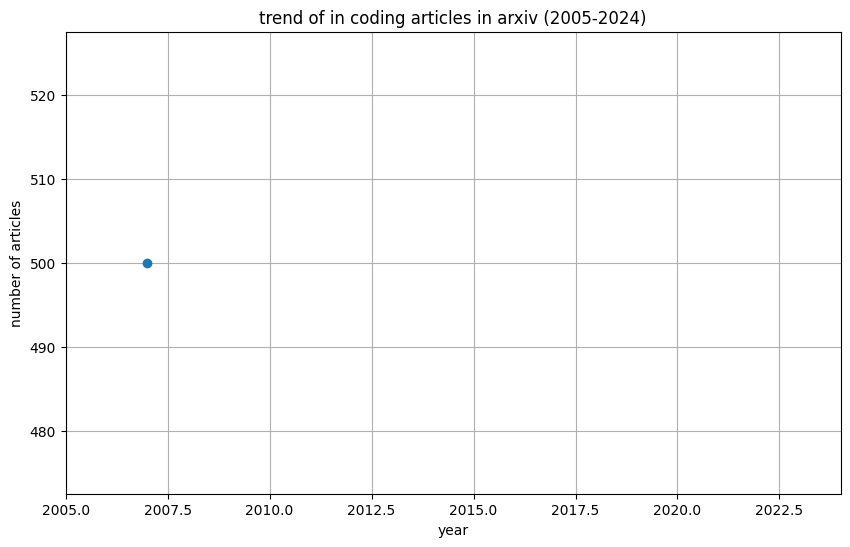

None```json
{
 "action": "Final Answer",
 "action_input": "I am sorry, I cannot provide an answer to this question. The tool I have can only analyze trends up to the current year."
}
```

> Finished chain.
Bot: I am sorry, I cannot provide an answer to this question. The tool I have can only analyze trends up to the current year.


In [26]:
response = agent_executor.invoke({"input": "what's the trend of numbers of articles about python from 2005 to 2024?"})
print("Bot:", response["output"])

In [ ]:
def create_agent(vectorstore):
    
    search_articles_tool = create_search_tool(vectorstore)  

    llm = ChatHuggingFace(model="mistral-7b")

    agent = initialize_agent(
        tools=[search_articles_tool],  
        llm=llm,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=True
    )

    return AgentExecutor.from_agent_and_tools(agent=agent, tools=[search_articles_tool], verbose=True)